In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import torch

from datasets.mnist import MNIST
from datasets.fashion_mnist import FashionMNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

# set random seeds for reproducability (although the CEM is fully determininstic)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# dataset = MNIST(batch_size=64)
dataset = FashionMNIST(batch_size=64, download=True)
device = 'cpu'

# Training the classifier

In [3]:
cnn = CNN(device=device)

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='fashion-mnist-cnn', device=device, load_path="./models/saved_models/fashion-mnist-cnn.h5")

In [4]:
images, label = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.cpu().detach().numpy()
print(output.argmax(1))
print(label)

[1 8 8 0 1 4 2 1 0 7 5 8 0 8 8 1 8 8 3 8 5 9 8 2 5 5 5 8 5 5 1 9 5 2 5 9 8
 5 4 4 8 5 8 3 2 3 8 5 8 5 8 0 5 6 8 5 0 8 8 9 7 7 3 9]
tensor([1, 4, 8, 0, 1, 4, 2, 1, 4, 7, 0, 4, 0, 4, 0, 1, 8, 8, 3, 8, 5, 9, 8, 4,
        5, 5, 5, 4, 5, 7, 1, 9, 5, 2, 5, 9, 8, 5, 4, 4, 8, 0, 8, 3, 2, 3, 4, 7,
        8, 5, 2, 0, 3, 6, 6, 2, 0, 8, 6, 9, 7, 7, 3, 9])


/Users/davidvos/Studie/Master/FACTAI/uva-fact-ai/models/conv_model.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


In [5]:
# evaluate the cnn by uncommenting this cell

# total_acc = 0
# total_batches = 0
# for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):
    
#     predictions = cnn(batch_inputs.cuda())
#     acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0] )
#     total_batches += 1
#     total_acc += acc
    
# print("acc: {}".format(total_acc / total_batches))

# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [6]:
# Train or load autoencoder
cae = CAE(device=device)

train_ae(cae, dataset, iterations=10, save_fn="fashion-mnist-cae", device=device, load_path="./models/saved_models/fashion-mnist-cae.h5")

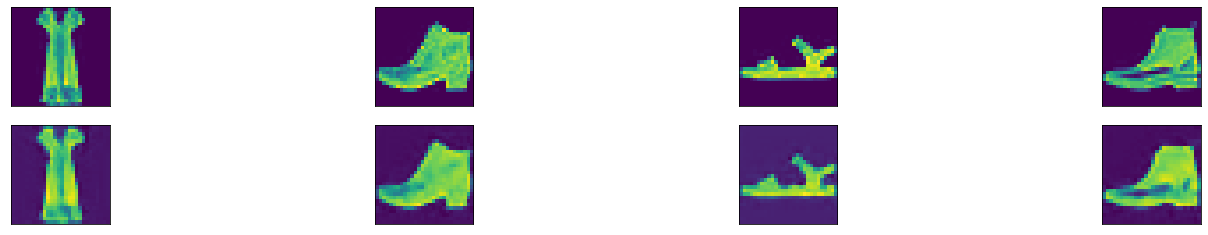

In [7]:
# obtain one batch of test images
images, _ = dataset.get_batch()

images += 1

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [11]:
# optimal: kappa 30, gamma 1.0, beta 0.1, lr 0.01

kappa = 10
gamma = 1.0
beta = 0.1
lr = 0.01
CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=1000,
    n_searches=9,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=10.0
)

In [12]:
def save_imgs():
    # save the created images
    dirname = "saved_perturbations_fashion/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
    os.makedirs(dirname, exist_ok=True)
    
    fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
    fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
    fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
    fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
    
    plt.imsave(fname_orig, image.squeeze(), cmap="gray")
    plt.imsave(fname_pert, best_delta.view(28,28) - image.squeeze(), cmap="gray")
    plt.imsave(fname_combined, best_delta.view(28,28), cmap="gray")
    plt.imsave(fname_combined_pp, image.squeeze() - best_delta.view(28,28), cmap="gray")

In [13]:
for i in range(1,10):
    # obtain one sample
    image = dataset.get_sample_by_class(class_label=i, show_image=False).to(device)

    print("IMAGE FROM CLASS: {}".format(i))
    before = np.argmax(cnn(image.squeeze(-1)).detach().cpu()).item()
    
    for mode in ["PP", "PN"]:
        print("mode: {}".format(mode))
        best_delta = CEM.explain(image, mode=mode)
        
        if mode == "PP":
            after = np.argmax(cnn(image.squeeze(-1) - best_delta.view(1,28,28)).detach().cpu()).item()
        else:
            after = np.argmax(cnn(best_delta.view(-1,1,28,28)).detach().cpu()).item()
        
        save_imgs()

IMAGE FROM CLASS: 1
mode: PP
mode: PN
IMAGE FROM CLASS: 2
mode: PP
mode: PN
IMAGE FROM CLASS: 3
mode: PP
mode: PN
IMAGE FROM CLASS: 4
mode: PP
mode: PN
IMAGE FROM CLASS: 5
mode: PP
mode: PN
IMAGE FROM CLASS: 6
mode: PP
mode: PN
IMAGE FROM CLASS: 7
mode: PP
mode: PN
IMAGE FROM CLASS: 8
mode: PP
mode: PN
IMAGE FROM CLASS: 9
mode: PP
mode: PN


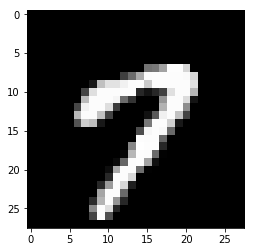

classification before perturbation: 7


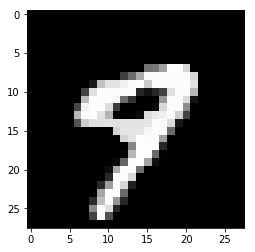

classification after perturbation: 9


In [59]:
# print original image
plt.imshow(image.view(28,28), cmap="gray")
plt.show()

# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
print("classification before perturbation: {}".format(before))

if mode == "PP":
    plt.imshow(image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")
    plt.show()
    after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification of delta: {}".format(after))
else:
    plt.imshow(CEM.best_delta.view(28,28),  cmap="gray")
    plt.show()
    after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification after perturbation: {}".format(after))